![banner](../img/cdips_2017_logo.png)

In [1]:
import seaborn as sns
%matplotlib inline
import folium
import numpy as np
import pandas as pd

In [2]:
#open a previously prepared file containing average long term rainfall data
#the csv file was prepared from TRMM3B42ALT_199801_201505.tif
#availbe from: ftp://africagrids.net/30000m/TRMM3B42/Average/
df = pd.read_csv('../data/mapping_data/avg_rainfall.csv')
df.head()

,lat,long,avg_rainfall
0,14.826494,-17.375158,1.201168
1,15.107157,-17.124348,1.240315
2,14.850534,-17.084277,1.289794
3,14.593885,-17.044908,1.498279
4,14.337212,-17.006235,1.637031


In [3]:
import matplotlib.cm as cm
import matplotlib
from matplotlib.colors import LogNorm

def convert_to_hex(rgba_color):
    """A hex converter"""
    #note that currently this only uses rgb. 
    #the transparency informatoin in 'a' is discarded
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#{r:02x}{g:02x}{b:02x}'.format(r=red,g=green,b=blue)


def color(x, scalemin=df['avg_rainfall'].min(), scalemax=df['avg_rainfall'].max(), log=True):
    """This function assigns a color based on the value of x"""
    if log:
        norm=LogNorm(vmin=scalemin, vmax=scalemax)
    else:
        norm =matplotlib.colors.Normalize(vmin=scalemin, vmax=scalemax)
    #select a color map from matplotlib
    cmap = cm.RdYlGn
    #get a scalar map based on the normalization and color map we choose
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #return the rbga color that the value of x corresponds to
    #convert it to hex for plotting with folium
    return convert_to_hex(m.to_rgba(x))
    


In [4]:
af = folium.Map(location=[-4, 21], zoom_start=3, tiles='cartodbpositron')

#Foilium requires a list of [lat, long] points, not an array
plist = []
for lat, long in zip(df.lat.values,df.long.values):
    plist.append([lat,long])

#since there are so many points we need to downsample
#otherwise we won't be able to plot
downsample = 100
for idx, p in enumerate(plist[::downsample]):
    rain = df.avg_rainfall.values[idx*downsample]
    col_idx = color(rain, log=False)
    folium.CircleMarker(location=p,radius=2, popup="%0.1f inches" %rain, fill_color=col_idx, color=col_idx).add_to(af)

af

# Introducing the RUNNING_LOCALLY variable

There are [known issues](https://forums.databricks.com/questions/10096/libgeos-not-found-needed-for-shapely.html) installing some of ```geopandas```' dependencies on Linux that preclude us from running some of our mapping code remotely. If you'd like to run this code yourself, you'll need to clone the repo to your own machine and install the dependencies noted in [requirements.txt](../requirements.txt).

In [5]:
RUNNING_LOCALLY = False

In [7]:
if RUNNING_LOCALLY:
    import geopandas as gpd

    #this shape file is downloaded from: 
    #https://www.arcgis.com/home/item.html?id=16da193d9bcd4ae0b74febe39730658a
    shp = gpd.GeoDataFrame.from_file('../data/mapping_data/AfricanCountires.shp')

    #let's take a look at what is in the shape file
    shp.head()


,CONTINENT,COUNTRY,COUNTRYAFF,ISO_CC,Land_Rank,Land_Type,OBJECTID,Shape_STAr,Shape_STLe,geometry
0,Africa,Algeria,Algeria,DZ,5,Primary land,5,213.064345,76.492678,(POLYGON ((7.214068629064002 37.08835575501411...
1,Africa,Algeria,Algeria,DZ,2,Small island,6,0.000057,0.043855,POLYGON ((-1.129058201874443 35.72460367751773...
2,Africa,Algeria,Algeria,DZ,1,Very small island,7,0.000169,0.316232,(POLYGON ((-1.476443665142995 35.3176683126425...
3,Africa,Angola,Angola,AO,5,Primary land,9,103.769595,69.704554,(POLYGON ((13.23957005831159 -9.20037470562812...
4,Africa,Angola,Angola,AO,2,Small island,10,0.016628,2.854778,(POLYGON ((11.70059379097074 -16.5078875572648...


In [8]:
if RUNNING_LOCALLY:

    print(shp.COUNTRY.unique())
    print('unique countries = ', len(shp.COUNTRY.unique()))
    print('Note that the UN recognizes 54 countries in Africa')

    #grab the polygons
    polys = shp.geometry.values


['Algeria' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Cape Verde' 'Central African Republic' 'Chad' 'Comoros' 'Congo'
 "CÃ´te d'Ivoire" 'Congo DRC' 'Djibouti' 'Egypt' 'Equatorial Guinea'
 'Eritrea' 'Ethiopia' 'French Southern Territories' 'Gabon' 'Gambia'
 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya' 'Lesotho' 'Liberia' 'Libya'
 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Mauritius' 'Morocco'
 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Madeira' 'RÃ©union' 'Rwanda'
 'Saint Helena' 'Sao Tome and Principe' 'Senegal' 'Seychelles'
 'Sierra Leone' 'Somalia' 'South Africa' 'Swaziland' 'Tanzania' 'Togo'
 'Tunisia' 'Uganda' 'Yemen' 'Zambia' 'Zimbabwe' 'Sudan' 'South Sudan'
 'Canarias' 'Spain' 'Mayotte']
unique countries =  62
Note that the UN recognizes 54 countries in Africa


In [9]:
#This block assigns a country to each lat,long point
#Note that it takes SEVERAL HOURS to run
#set the following variable to true to actually run the code
#else get it from a file
HAVE_ALL_DAY = False

if RUNNING_LOCALLY:
    from shapely.geometry import shape, Point

    def check(lon, lat, polygon):
        # build a shapely point from your geopoint
        point = Point(lon, lat)
        # the contains function does exactly what you want
        return polygon.contains(point)

    if HAVE_ALL_DAY:
        contained_in = []
        for lat, long in zip(df.lat.values, df.long.values):
            gotit = False
            for poly, country in zip(polys, shp.COUNTRY.values):
                # build a shapely polygon from your shape
                polygon = shape(poly)
                if gotit:
                    break;
                if check(long, lat, polygon):
                    contained_in.append(country)
                    gotit = True
            if not gotit: #if never find it
                contained_in.append('None')

        #make a pandas series out of the list
        ctry = pd.Series(contained_in)
        #add it to the dataframe
        df['Country'] = ctry.values

    else:
        print('Go to next cell for previously prepared file')

Go to next cell for previously prepared file


# Per-Country Information

The following code gets a previously prepared .csv that sorts each (lat,long) point into a country.
You can run the following on binder.

Note that some of the (lat,long) points didn't get sorted into countries. Assigning a country to a latitude-longitude point is subject to a shape file's accuracy.


In [10]:
df2 = pd.read_csv('../data/mapping_data/avg_rainfall_country.csv')
df2.head()

,lat,long,avg_rainfall,Country
0,14.826494,-17.375158,1.201168,None
1,15.107157,-17.124348,1.240315,None
2,14.850534,-17.084277,1.289794,Senegal
3,14.593885,-17.044908,1.498279,Senegal
4,14.337212,-17.006235,1.637031,None


In [11]:
tr = df2['Country'] == 'None'
print(sum(tr), ' points were not assigned a country')

326  points were not assigned a country


In [12]:
af = folium.Map(location=[-4, 21], zoom_start=3, tiles='cartodbpositron')

#Foilium requires a list of [lat, long] points, not an array
plist = []
for lat, long in zip(df[tr].lat.values,df[tr].long.values):
    plist.append([lat,long])

#let's see where they are
downsample = 5 #set to 1 for no down-sampling
for idx, p in enumerate(plist[::downsample]):
    rain = df.avg_rainfall.values[idx*downsample]
    col_idx = color(rain, log=False)
    folium.CircleMarker(location=p,radius=2, popup="%0.1f inches" %rain, fill_color=col_idx, color=col_idx).add_to(af)

#we can see that assigning a country to a latitude-longitude point is subject to the shape file's accuracy
af

# Average Rainfaill By Country

Noting that the points which are sorted into 'None' country will be lost, we can get the average rainfall in each country. 

In [13]:
#get avg rainfall per country
means = df2.groupby(['Country'])['avg_rainfall'].mean()
#means = pd.DataFrame(means)
#means.head()
CountryNames = list(means.index)
AverageRainfall = list(means)
#sort ascending so it plots prettier
CountryNames = [x for y, x in sorted(zip(AverageRainfall, CountryNames))]
AverageRainfall.sort()


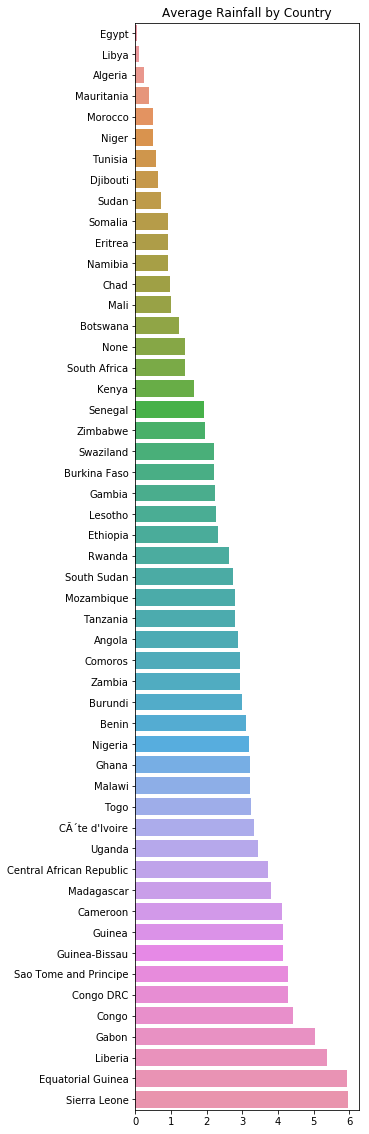

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,20))
plt.title('Average Rainfall by Country')
sns.barplot(y=CountryNames,x=AverageRainfall, orient="h");